In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier


In [2]:
min_features = pd.read_csv('/Users/sabrinasayed/Documents/GitHub/Data_Center_Sites/Data/Minimum_Features.csv', index_col=0)
min_features.head()

,State,County,Risk_Score,Risk_Rating,IXP_Count,Region,Regional Electricity Demand,State Emissions Level,Utility Annual Energy Savings (MWh),SAIFI Major Events,CAIDI w/o Major Events,CAIDI w/ Major Events,Commercial Generation Rank,Total Generation Rank
60,AL,Autauga,49.220489977728285,Relatively Low,8.0,SE,Moderate,High,Moderate,Moderate,122.8,186.9,Low,High
61,AL,Autauga County,Unknown,Unknown,8.0,SE,Moderate,High,Moderate,Moderate,122.8,186.9,Low,High
62,AL,Baldwin,97.70919503658924,Relatively High,8.0,SE,Moderate,High,Moderate,Moderate,122.8,186.9,Low,High
63,AL,Baldwin County,Unknown,Unknown,8.0,SE,Moderate,High,Moderate,Moderate,122.8,186.9,Low,High
64,AL,Barbour,56.188355074769326,Relatively Low,8.0,SE,Moderate,High,Moderate,Moderate,122.8,186.9,Low,High


In [3]:
min_features = min_features.replace('Unknown', np.nan)
min_features.info()


<class 'pandas.core.frame.DataFrame'>
Index: 7455 entries, 60 to 9556
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   State                                7455 non-null   object 
 1   County                               7455 non-null   object 
 2   Risk_Score                           2189 non-null   object 
 3   Risk_Rating                          2189 non-null   object 
 4   IXP_Count                            7455 non-null   float64
 5   Region                               7455 non-null   object 
 6   Regional Electricity Demand          7455 non-null   object 
 7   State Emissions Level                7413 non-null   object 
 8   Utility Annual Energy Savings (MWh)  7455 non-null   object 
 9   SAIFI Major Events                   7455 non-null   object 
 10  CAIDI w/o Major Events               7455 non-null   float64
 11  CAIDI w/ Major Events             

## Propagate missing state level data

In [4]:
# Convert Risk Score to float
min_features['Risk_Score'] = min_features['Risk_Score'].astype(float)

# Propagate Risk Score with state-level aggregation
state_means = min_features.groupby('State')['Risk_Score'].transform('mean')


# Fill NaN values with their respective state means
min_features['Risk_Score'] = min_features['Risk_Score'].fillna(state_means)


In [5]:
min_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7455 entries, 60 to 9556
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   State                                7455 non-null   object 
 1   County                               7455 non-null   object 
 2   Risk_Score                           7455 non-null   float64
 3   Risk_Rating                          2189 non-null   object 
 4   IXP_Count                            7455 non-null   float64
 5   Region                               7455 non-null   object 
 6   Regional Electricity Demand          7455 non-null   object 
 7   State Emissions Level                7413 non-null   object 
 8   Utility Annual Energy Savings (MWh)  7455 non-null   object 
 9   SAIFI Major Events                   7455 non-null   object 
 10  CAIDI w/o Major Events               7455 non-null   float64
 11  CAIDI w/ Major Events             

In [6]:
min_features['Risk_Score'].value_counts()

Risk_Score
54.099098    980
90.590475    809
45.688109    262
55.326737    260
45.737058    219
            ... 
39.707286      1
1.940821       1
7.445116       1
5.599745       1
60.483614      1
Name: count, Length: 2221, dtype: int64

/var/folders/rj/3yvmqxnj3d17zpgh8wpywxvr0000gn/T/ipykernel_38382/1889621174.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_stats = risk_analysis.groupby('Risk_Rating')['Risk_Score'].agg(['min', 'max', 'mean', 'count'])



Risk Score Statistics by Rating:
                           min         max       mean  count
Risk_Rating                                                 
Relatively Low       48.106904   82.787146  65.923185    787
Very Low              0.031817   48.075087  24.725265    982
Relatively Moderate  82.818963   95.418390  89.174811    297
Relatively High      95.450207   99.522749  97.489424    108
Very High            99.554566  100.000000  99.777283     15


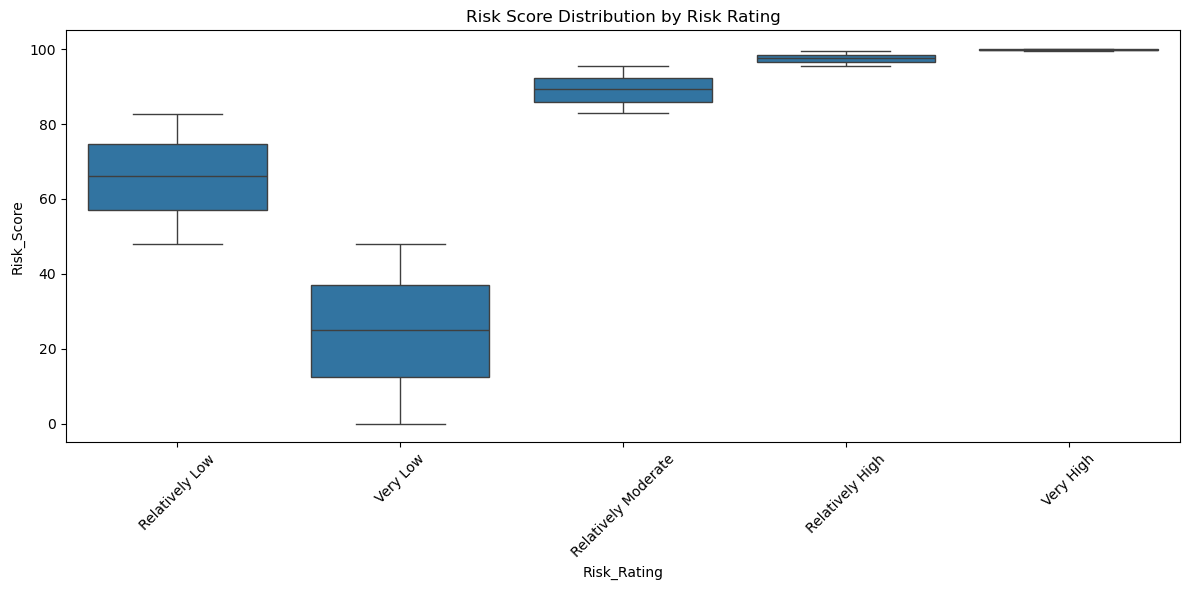

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
# Define the desired order
risk_order = ['Relatively Low', 'Very Low', 'Relatively Moderate', 'Relatively High', 'Very High']

# First, let's look at the Risk_Score distribution for each Risk_Rating category
risk_analysis = min_features.copy()
risk_analysis['Risk_Rating'] = min_features['Risk_Rating']

# Convert Risk_Rating to categorical with custom order
risk_analysis['Risk_Rating'] = pd.Categorical(risk_analysis['Risk_Rating'], 
                                            categories=risk_order, 
                                            ordered=True)

# Group by Risk_Rating and get statistics for Risk_Score
risk_stats = risk_analysis.groupby('Risk_Rating')['Risk_Score'].agg(['min', 'max', 'mean', 'count'])
print("\nRisk Score Statistics by Rating:")
print(risk_stats)

# Visualize the distribution
plt.figure(figsize=(12, 6))
sns.boxplot(data=risk_analysis, x='Risk_Rating', y='Risk_Score')
plt.title('Risk Score Distribution by Risk Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
def assign_risk_rating(score):
    if score <= 48.075087:  # Very Low max
        return 'Very Low'
    elif score <= 82.787146:  # Relatively Low max
        return 'Relatively Low'
    elif score <= 95.418390:  # Relatively Moderate max
        return 'Relatively Moderate'
    elif score <= 99.522749:  # Relatively High max
        return 'Relatively High'
    else:  # Above 99.522749
        return 'Very High'

# Apply the function to fill missing Risk_Ratings
min_features['Risk_Rating'] = min_features['Risk_Score'].apply(assign_risk_rating)

min_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7455 entries, 60 to 9556
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   State                                7455 non-null   object 
 1   County                               7455 non-null   object 
 2   Risk_Score                           7455 non-null   float64
 3   Risk_Rating                          7455 non-null   object 
 4   IXP_Count                            7455 non-null   float64
 5   Region                               7455 non-null   object 
 6   Regional Electricity Demand          7455 non-null   object 
 7   State Emissions Level                7413 non-null   object 
 8   Utility Annual Energy Savings (MWh)  7455 non-null   object 
 9   SAIFI Major Events                   7455 non-null   object 
 10  CAIDI w/o Major Events               7455 non-null   float64
 11  CAIDI w/ Major Events             

In [12]:
min_features['Risk_Rating'].value_counts()

Risk_Rating
Relatively Low         3656
Very Low               2322
Relatively Moderate    1353
Relatively High         109
Very High                15
Name: count, dtype: int64

In [21]:
min_features.drop(columns=['Risk_Score'], inplace=True)

In [22]:
# Bin the IXP_Count column into categories using distribution

def assign_ixp_count(count):
    if count >= 100:
        return 'High'
    elif count >= 18:
        return 'Moderate'
    else:
        return 'Low'
    
min_features['IXP_Count'] = min_features['IXP_Count'].apply(assign_ixp_count)
min_features['IXP_Count'].value_counts()


IXP_Count
Low         1841
Moderate    1621
High        1332
Name: count, dtype: int64

In [23]:
min_features.describe()

,CAIDI w/o Major Events,CAIDI w/ Major Events
count,4794.000000,4794.000000
mean,119.302128,242.220129
std,20.207773,107.931629
min,84.100000,108.600000
25%,106.100000,165.600000
50%,119.400000,248.100000
75%,138.400000,281.500000
max,176.700000,723.500000


In [24]:
# Bin CAIDI metrics based on distribution
def assign_cai_rating(cai):
    if cai <= 106:
        return 'Low'
    elif cai <= 138:
        return 'Moderate'
    else:
        return 'High'
    
min_features['CAIDI w/o Major Events'] = min_features['CAIDI w/o Major Events'].apply(assign_cai_rating)

def assign_caiME_rating(cai):
    if cai <= 165:
        return 'Low'
    elif cai <= 281:
        return 'Moderate'
    else:
        return 'High'
min_features['CAIDI w/ Major Events'] = min_features['CAIDI w/ Major Events'].apply(assign_caiME_rating)
min_features.head()

,State,County,Risk_Rating,IXP_Count,Region,Regional Electricity Demand,Utility Annual Energy Savings (MWh),SAIFI Major Events,CAIDI w/o Major Events,CAIDI w/ Major Events,Commercial Generation Rank,Total Generation Rank
61,AL,Autauga County,Relatively Low,Low,SE,Moderate,Moderate,Moderate,Moderate,Moderate,Low,High
63,AL,Baldwin County,Relatively Low,Low,SE,Moderate,Moderate,Moderate,Moderate,Moderate,Low,High
65,AL,Barbour County,Relatively Low,Low,SE,Moderate,Moderate,Moderate,Moderate,Moderate,Low,High
67,AL,Bibb County,Relatively Low,Low,SE,Moderate,Moderate,Moderate,Moderate,Moderate,Low,High
69,AL,Blount County,Relatively Low,Low,SE,Moderate,Moderate,Moderate,Moderate,Moderate,Low,High


In [13]:
min_features.drop(columns=['State Emissions Level'], inplace=True)
min_features.info()


<class 'pandas.core.frame.DataFrame'>
Index: 7455 entries, 60 to 9556
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   State                                7455 non-null   object 
 1   County                               7455 non-null   object 
 2   Risk_Score                           7455 non-null   float64
 3   Risk_Rating                          7455 non-null   object 
 4   IXP_Count                            7455 non-null   float64
 5   Region                               7455 non-null   object 
 6   Regional Electricity Demand          7455 non-null   object 
 7   Utility Annual Energy Savings (MWh)  7455 non-null   object 
 8   SAIFI Major Events                   7455 non-null   object 
 9   CAIDI w/o Major Events               7455 non-null   float64
 10  CAIDI w/ Major Events                7455 non-null   float64
 11  Commercial Generation Rank        

In [14]:
#Drop missing values
min_features.dropna(inplace=True)
min_features.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6808 entries, 60 to 9556
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   State                                6808 non-null   object 
 1   County                               6808 non-null   object 
 2   Risk_Score                           6808 non-null   float64
 3   Risk_Rating                          6808 non-null   object 
 4   IXP_Count                            6808 non-null   float64
 5   Region                               6808 non-null   object 
 6   Regional Electricity Demand          6808 non-null   object 
 7   Utility Annual Energy Savings (MWh)  6808 non-null   object 
 8   SAIFI Major Events                   6808 non-null   object 
 9   CAIDI w/o Major Events               6808 non-null   float64
 10  CAIDI w/ Major Events                6808 non-null   float64
 11  Commercial Generation Rank        

In [28]:
min_features = min_features.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
min_features.head()


,State,County,Risk_Rating,IXP_Count,Region,Regional Electricity Demand,Utility Annual Energy Savings (MWh),SAIFI Major Events,CAIDI w/o Major Events,CAIDI w/ Major Events,Commercial Generation Rank,Total Generation Rank
61,AL,Autauga County,Relatively Low,Low,SE,Moderate,Moderate,Moderate,Moderate,Moderate,Low,High
63,AL,Baldwin County,Relatively Low,Low,SE,Moderate,Moderate,Moderate,Moderate,Moderate,Low,High
65,AL,Barbour County,Relatively Low,Low,SE,Moderate,Moderate,Moderate,Moderate,Moderate,Low,High
67,AL,Bibb County,Relatively Low,Low,SE,Moderate,Moderate,Moderate,Moderate,Moderate,Low,High
69,AL,Blount County,Relatively Low,Low,SE,Moderate,Moderate,Moderate,Moderate,Moderate,Low,High


In [29]:
# 1. Ensure all county names end with 'County'
min_features = min_features[min_features['County'].str.endswith('County')]

# 2. Verify no duplicates exist
print("Number of duplicate State-County pairs:", 
      min_features.groupby(['State', 'County']).size().value_counts().iloc[1:])

Number of duplicate State-County pairs: 3      8
15     7
4      5
25     5
13     4
7      4
61     4
20     3
11     3
29     3
16     3
56     3
9      3
10     2
140    2
91     2
2      2
156    2
6      2
85     2
17     2
97     1
26     1
43     1
22     1
8      1
5      1
287    1
90     1
31     1
131    1
14     1
141    1
Name: count, dtype: int64


In [30]:
min_features.groupby(['State', 'County']).size()

State  County          
AL     Autauga County      1
       Baldwin County      1
       Barbour County      1
       Bibb County         1
       Blount County       1
                          ..
WI     Waukesha County     1
       Waupaca County      1
       Waushara County     1
       Winnebago County    1
       Wood County         1
Length: 1947, dtype: int64

In [31]:
min_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4794 entries, 61 to 9556
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   State                                4794 non-null   object
 1   County                               4794 non-null   object
 2   Risk_Rating                          4794 non-null   object
 3   IXP_Count                            4794 non-null   object
 4   Region                               4794 non-null   object
 5   Regional Electricity Demand          4794 non-null   object
 6   Utility Annual Energy Savings (MWh)  4794 non-null   object
 7   SAIFI Major Events                   4794 non-null   object
 8   CAIDI w/o Major Events               4794 non-null   object
 9   CAIDI w/ Major Events                4794 non-null   object
 10  Commercial Generation Rank           4794 non-null   object
 11  Total Generation Rank                4794 non-n

In [32]:
min_features.head()

,State,County,Risk_Rating,IXP_Count,Region,Regional Electricity Demand,Utility Annual Energy Savings (MWh),SAIFI Major Events,CAIDI w/o Major Events,CAIDI w/ Major Events,Commercial Generation Rank,Total Generation Rank
61,AL,Autauga County,Relatively Low,Low,SE,Moderate,Moderate,Moderate,Moderate,Moderate,Low,High
63,AL,Baldwin County,Relatively Low,Low,SE,Moderate,Moderate,Moderate,Moderate,Moderate,Low,High
65,AL,Barbour County,Relatively Low,Low,SE,Moderate,Moderate,Moderate,Moderate,Moderate,Low,High
67,AL,Bibb County,Relatively Low,Low,SE,Moderate,Moderate,Moderate,Moderate,Moderate,Low,High
69,AL,Blount County,Relatively Low,Low,SE,Moderate,Moderate,Moderate,Moderate,Moderate,Low,High


# Feature Encoding

In [33]:
categorical_cols = {
    #Ordinal categories
    'Regional Electricity Demand': ['Low', 'Moderate', 'High'],
    'Utility Annual Energy Savings (MWh)': ['Low', 'Moderate', 'High'],
    'SAIFI Major Events': ['Low', 'Moderate', 'High'],
    'Commercial Generation Rank': ['Low', 'Moderate', 'High'],
    'Total Generation Rank': ['Low', 'Moderate', 'High'],
    'IXP_Count': ['Low', 'Moderate', 'High'],
    'CAIDI w/o Major Events': ['Low', 'Moderate', 'High'],
    'CAIDI w/ Major Events': ['Low', 'Moderate', 'High']

}


# Convert and encode ordinal categories
for col, categories in categorical_cols.items():
    min_features[col] = pd.Categorical(min_features[col], 
                                         categories=categories, 
                                         ordered=True)
    min_features[col] = min_features[col].cat.codes


In [34]:
min_features.head()

,State,County,Risk_Rating,IXP_Count,Region,Regional Electricity Demand,Utility Annual Energy Savings (MWh),SAIFI Major Events,CAIDI w/o Major Events,CAIDI w/ Major Events,Commercial Generation Rank,Total Generation Rank
61,AL,Autauga County,Relatively Low,0,SE,1,1,1,1,1,0,2
63,AL,Baldwin County,Relatively Low,0,SE,1,1,1,1,1,0,2
65,AL,Barbour County,Relatively Low,0,SE,1,1,1,1,1,0,2
67,AL,Bibb County,Relatively Low,0,SE,1,1,1,1,1,0,2
69,AL,Blount County,Relatively Low,0,SE,1,1,1,1,1,0,2


In [35]:
min_features.isna().value_counts()

State  County  Risk_Rating  IXP_Count  Region  Regional Electricity Demand  Utility Annual Energy Savings (MWh)  SAIFI Major Events  CAIDI w/o Major Events  CAIDI w/ Major Events  Commercial Generation Rank  Total Generation Rank
False  False   False        False      False   False                        False                                False               False                   False                  False                       False                    4794
Name: count, dtype: int64

## Labeling Data
- Reliability
- Connectivity
- Efficiency/Cost
- Capacity

In [ ]:
high_is_better = ['IXP_Count', 'Utility Annual Energy Savings (MWh)', 'Commercial Generation Rank', 'Total Generation Rank']
low_is_better = ['Risk_Rating','Regional Electricity Demand', 'SAIFI Major Events', 'CAIDI w/o Major Events', 'CAIDI w/ Major Events']

def score_feature(value, categories):
    if categories.isin(high_is_better):
        return{}

In [ ]:
# Define scoring thresholds for each feature based on their distributions
feature_thresholds = {
    # Connectivity features
    'IXP_Count': {
        'High': 100,  # Example: Counties with 100+ IXPs get highest score
        'Moderate': 18,
        'Low': 8
    },
    
    # Reliability features
    'Regional Electricity Demand': {
        'excellent': 'Low',
        'good': 'Moderate',
        'fair': 'High'
    },
    'SAIFI Major Events': {
        'excellent': 'Low',
        'good': 'Moderate',
        'fair': 'High'
    },
    'CAIDI w/ Major Events': {
        'excellent': 'Low',
        'good': 'Moderate',
        'fair': 'High'
    },
    'CAIDI w/o Major Events': {
        'excellent': 'Low',
        'good': 'Moderate',
        'fair': 'High'
    },
    
    # Efficiency features
    'Utility Annual Energy Savings (MWh)': {
        'excellent': 'High',
        'good': 'Moderate',
        'fair': 'Low'
    },
    
    # Capacity features
    'Commercial Generation Rank': {
        'excellent': 'High',
        'good': 'Moderate',
        'fair': 'Low'
    },
    'Total Generation Rank': {
        'excellent': 'High',
        'good': 'Moderate',
        'fair': 'Low'
    }
}

def score_feature(value, thresholds, is_categorical=False):
    if is_categorical:
        if value == thresholds['excellent']:
            return 3
        elif value == thresholds['good']:
            return 2
        elif value == thresholds['fair']:
            return 1
    else:
        if value >= thresholds['excellent']:
            return 3
        elif value >= thresholds['good']:
            return 2
        elif value >= thresholds['fair']:
            return 1
    return 0

# Calculate category scores
category_scores = pd.DataFrame(index=min_features.index)

# Connectivity score (based on IXP_Count)
category_scores['connectivity'] = min_features['IXP_Count'].apply(
    lambda x: score_feature(x, feature_thresholds['IXP_Count'])
)

# Reliability score (average of reliability features)
reliability_features = ['Regional Electricity Demand', 'SAIFI Major Events', 
                       'CAIDI w/ Major Events', 'CAIDI w/o Major Events']
reliability_scores = []
for feat in reliability_features:
    score = min_features[feat].apply(
        lambda x: score_feature(x, feature_thresholds[feat], is_categorical=True)
    )
    reliability_scores.append(score)
category_scores['reliability'] = sum(reliability_scores) / len(reliability_scores)

# Efficiency score
category_scores['efficiency'] = min_features['Utility Annual Energy Savings (MWh)'].apply(
    lambda x: score_feature(x, feature_thresholds['Utility Annual Energy Savings (MWh)'], 
                          is_categorical=True)
)

# Capacity score
capacity_features = ['Commercial Generation Rank', 'Total Generation Rank']
capacity_scores = []
for feat in capacity_features:
    score = min_features[feat].apply(
        lambda x: score_feature(x, feature_thresholds[feat], is_categorical=True)
    )
    capacity_scores.append(score)
category_scores['capacity'] = sum(capacity_scores) / len(capacity_scores)

# Create final suitability labels based on category scores
def assign_suitability(row):
    # A location is suitable if it scores well (≥2) in at least 3 categories
    excellent_categories = sum(row >= 2)
    return 'Suitable' if excellent_categories >= 3 else 'Unsuitable'

min_features['Suitability'] = category_scores.apply(assign_suitability, axis=1)

In [23]:
category_scores.describe()

,connectivity,reliability,efficiency,capacity
count,4794.000000,4794.000000,4794.000000,4794.000000
mean,0.047969,0.615941,0.541927,0.785044
std,0.164089,0.159292,0.377649,0.289963
min,0.000000,0.125000,0.000000,0.000000
25%,0.000302,0.542366,0.500000,0.500000
50%,0.000734,0.620309,0.500000,1.000000
75%,0.005482,0.695716,1.000000,1.000000
max,1.000000,0.998110,1.000000,1.000000


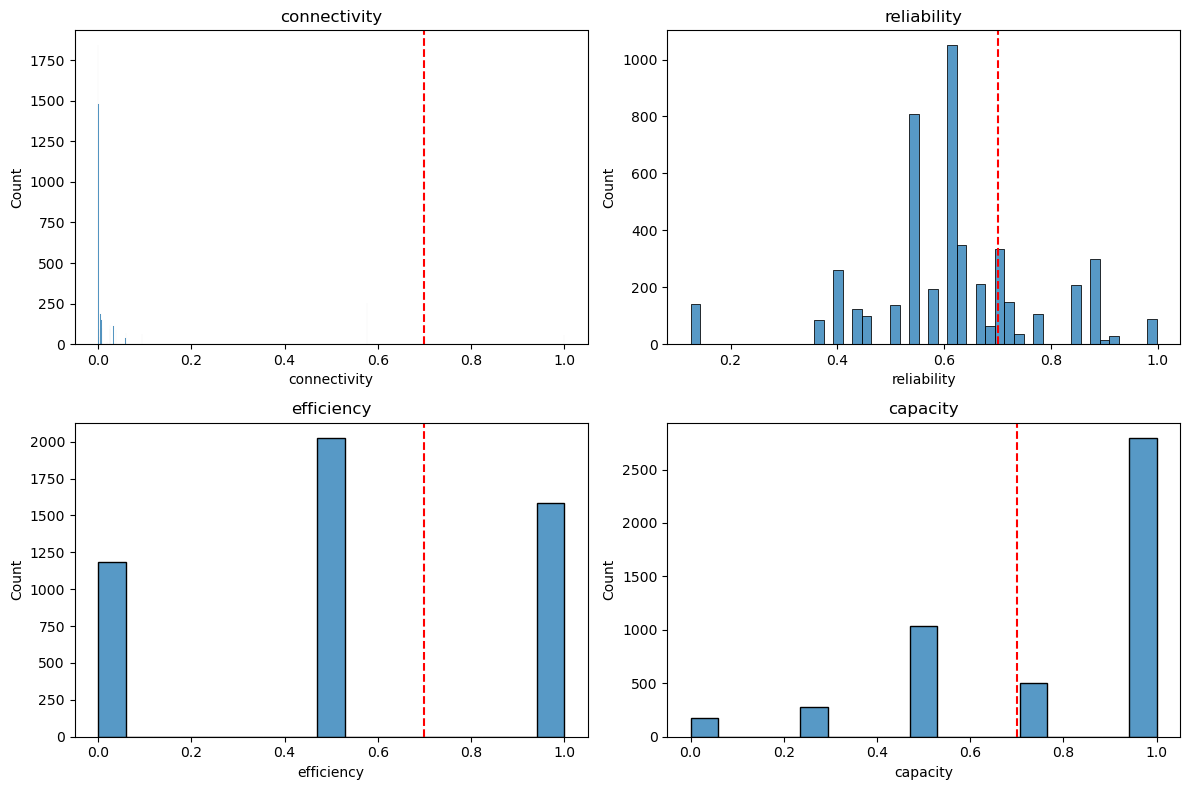

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for (column, ax) in zip(category_scores.columns, axes.ravel()):
    sns.histplot(category_scores[column], ax=ax)
    ax.set_title(column)
    ax.axvline(x=0.7, color='r', linestyle='--', label='Current threshold')
plt.tight_layout()
plt.show()

In [25]:
# Category specific thresholds based on the distribution

thresholds = {}

thresholds['capacity'] = 0.7
thresholds['reliability'] = 0.7
thresholds['efficiency'] = 0.7
thresholds['connectivity'] = 0.5


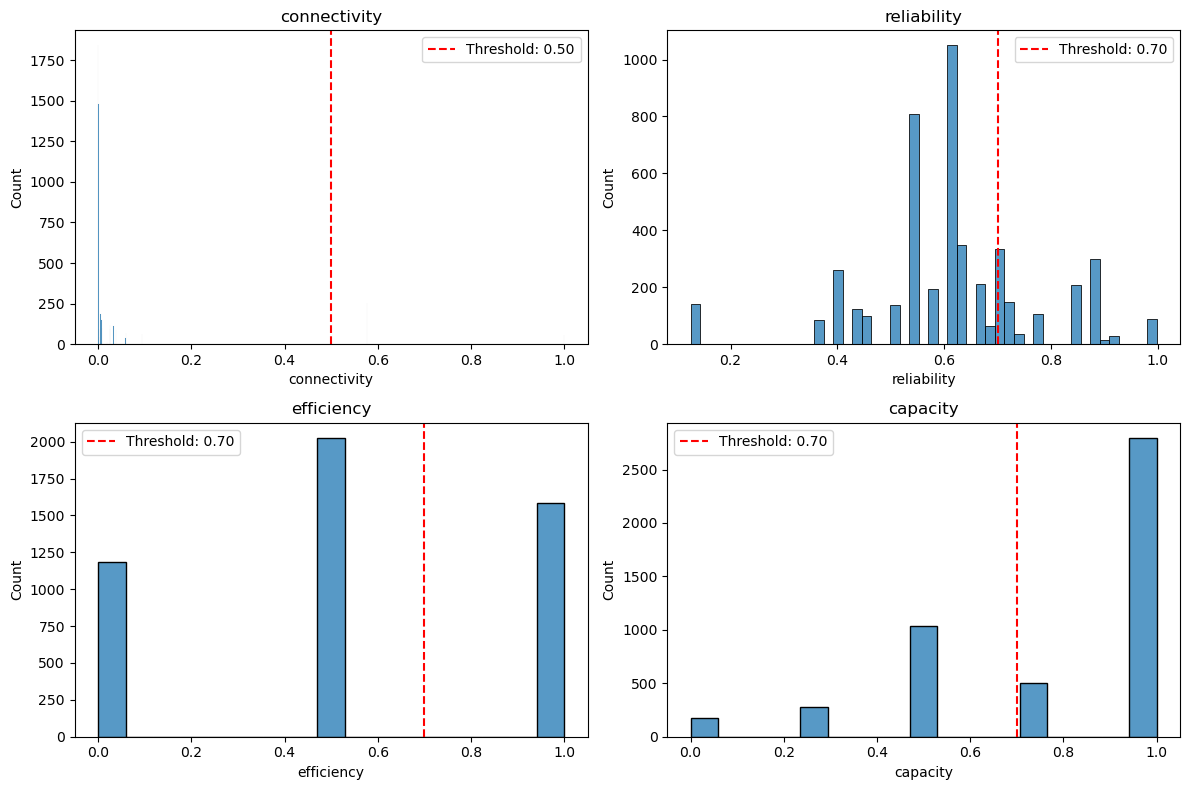

In [26]:
category_excellence = pd.DataFrame()
for col in category_scores.columns:
    category_excellence[col] = category_scores[col] >= thresholds[col]



fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for (column, ax) in zip(category_scores.columns, axes.ravel()):
    sns.histplot(category_scores[column], ax=ax)
    ax.set_title(column)
    ax.axvline(x=thresholds[column], color='r', linestyle='--', 
               label=f'Threshold: {thresholds[column]:.2f}')
    ax.legend()
plt.tight_layout()
plt.show()


In [27]:

# Create final suitability labels
def assign_suitability(row):
    excellent_categories = sum(row)
    if excellent_categories >= 3:
        return 'Suitable'
    else:
        return 'Unsuitable'

min_features['Suitability'] = category_excellence.apply(assign_suitability, axis=1)

# 5. Print summary statistics
print("\nCategory Score Statistics:")
print(category_scores.describe())
print("\nSuitability Distribution:")
print(min_features['Suitability'].value_counts(normalize=True))


Category Score Statistics:
       connectivity  reliability   efficiency     capacity
count   4794.000000  4794.000000  4794.000000  4794.000000
mean       0.047969     0.615941     0.541927     0.785044
std        0.164089     0.159292     0.377649     0.289963
min        0.000000     0.125000     0.000000     0.000000
25%        0.000302     0.542366     0.500000     0.500000
50%        0.000734     0.620309     0.500000     1.000000
75%        0.005482     0.695716     1.000000     1.000000
max        1.000000     0.998110     1.000000     1.000000

Suitability Distribution:
Suitability
Unsuitable    0.889028
Suitable      0.110972
Name: proportion, dtype: float64



Suitability Distribution:
Suitability
Unsuitable    88.9
Suitable      11.1
Name: proportion, dtype: float64

Average Scores by Suitability Class:
             connectivity  reliability  efficiency  capacity
Suitability                                                 
Suitable         0.284676     0.769943    1.000000  0.971805
Unsuitable       0.018423     0.596718    0.484749  0.761732


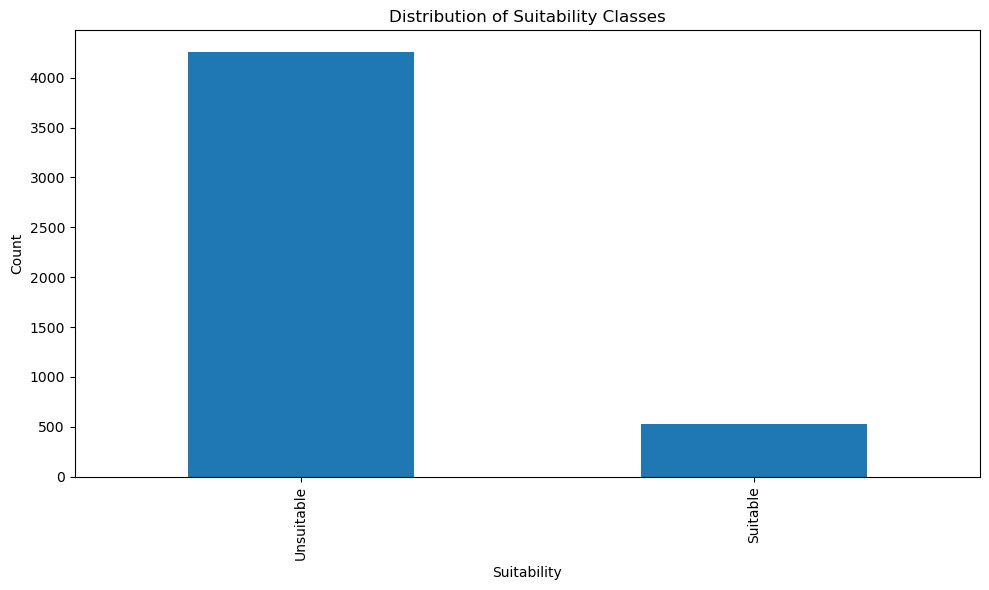

In [28]:
# Print summary statistics
print("\nSuitability Distribution:")
print(min_features['Suitability'].value_counts(normalize=True).mul(100).round(1))

# Optional: Look at characteristics of each group
print("\nAverage Scores by Suitability Class:")
print(pd.DataFrame({
    'Suitability': min_features['Suitability'],
    **category_scores
}).groupby('Suitability').mean())

# Visualize the distribution
plt.figure(figsize=(10, 6))
min_features['Suitability'].value_counts().plot(kind='bar')
plt.title('Distribution of Suitability Classes')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [29]:
# Inverse label encoder 
decoded_features = min_features.copy()

decoded_features['State'] = state_encoder.inverse_transform(min_features['State'])
decoded_features['County'] = county_encoder.inverse_transform(min_features['County'])
decoded_features['Region'] = region_encoder.inverse_transform(min_features['Region'])

suitable_sites = decoded_features[decoded_features['Suitability'] == 'Suitable']

In [30]:
suitable_sites.info()

<class 'pandas.core.frame.DataFrame'>
Index: 532 entries, 348 to 8725
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   State                                532 non-null    object 
 1   County                               532 non-null    object 
 2   Risk_Score                           532 non-null    float64
 3   IXP_Count                            532 non-null    float64
 4   Region                               532 non-null    object 
 5   Regional Electricity Demand          532 non-null    int8   
 6   Utility Annual Energy Savings (MWh)  532 non-null    int8   
 7   SAIFI Major Events                   532 non-null    int8   
 8   CAIDI w/o Major Events               532 non-null    float64
 9   CAIDI w/ Major Events                532 non-null    float64
 10  Commercial Generation Rank           532 non-null    int8   
 11  Total Generation Rank             

In [32]:
suitable_sites.groupby(['State']).size().tail(30)

State
AZ     60
FL     20
NY    200
TX    252
dtype: int64

# Model with CatBoost


In [34]:
min_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4794 entries, 61 to 9556
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   State                                4794 non-null   int64  
 1   County                               4794 non-null   int64  
 2   Risk_Score                           4794 non-null   float64
 3   IXP_Count                            4794 non-null   float64
 4   Region                               4794 non-null   int64  
 5   Regional Electricity Demand          4794 non-null   int8   
 6   Utility Annual Energy Savings (MWh)  4794 non-null   int8   
 7   SAIFI Major Events                   4794 non-null   int8   
 8   CAIDI w/o Major Events               4794 non-null   float64
 9   CAIDI w/ Major Events                4794 non-null   float64
 10  Commercial Generation Rank           4794 non-null   int8   
 11  Total Generation Rank             

In [35]:
min_features['Suitability'].value_counts()

Suitability
Unsuitable    4262
Suitable       532
Name: count, dtype: int64

In [36]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = min_features.drop(columns=['Suitability'])
y = min_features['Suitability']

le_suitability = LabelEncoder()
y_encoded = le_suitability.fit_transform(y)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [37]:
model = CatBoostClassifier(iterations=100, depth=2, learning_rate=0.1, random_seed=42)
model.fit(X_train, y_train)


0:	learn: 0.6121606	total: 77.6ms	remaining: 7.68s
1:	learn: 0.5460595	total: 79.2ms	remaining: 3.88s
2:	learn: 0.4914027	total: 80.3ms	remaining: 2.59s
3:	learn: 0.4439639	total: 81.4ms	remaining: 1.95s
4:	learn: 0.4031156	total: 82.7ms	remaining: 1.57s
5:	learn: 0.3673726	total: 84.2ms	remaining: 1.32s
6:	learn: 0.3342436	total: 85.2ms	remaining: 1.13s
7:	learn: 0.3073860	total: 86.5ms	remaining: 995ms
8:	learn: 0.2839630	total: 88.2ms	remaining: 891ms
9:	learn: 0.2608376	total: 89.6ms	remaining: 806ms
10:	learn: 0.2407326	total: 91.2ms	remaining: 738ms
11:	learn: 0.2229245	total: 92.1ms	remaining: 675ms
12:	learn: 0.2088486	total: 93ms	remaining: 622ms
13:	learn: 0.1941383	total: 93.6ms	remaining: 575ms
14:	learn: 0.1810778	total: 94.1ms	remaining: 533ms
15:	learn: 0.1704117	total: 94.6ms	remaining: 497ms
16:	learn: 0.1587341	total: 95.9ms	remaining: 468ms
17:	learn: 0.1493979	total: 97.7ms	remaining: 445ms
18:	learn: 0.1419065	total: 99.6ms	remaining: 425ms
19:	learn: 0.1336848	tot

In [38]:
# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       110
           1       1.00      1.00      1.00       849

    accuracy                           1.00       959
   macro avg       1.00      1.00      1.00       959
weighted avg       1.00      1.00      1.00       959

